# Gradient Descent Practice DEMO: Analyzing Parameter Estimation with Noise

This Notebook demonstrates the process of estimating optimal parameters in a linear model using Gradient Descent through the following steps:

1. **Setting Initial Parameters**: We start by defining initial values for model parameters $b$, $\theta_1$, and $\theta_2$. These represent the "ideal" relationship between $x$ and $y$ in a noise-free scenario.

2. **Adding Noise**: To make the data more realistic, we introduce a random noise component $epsilon$ to the model. This noise simulates real-world data variability, where observations are often subject to random fluctuations.

3. **Parameter Estimation**: Given the noisy data, we use Gradient Descent to iteratively adjust our parameter estimates. Our goal is to find parameters $\hat{b}$, $\hat{\theta}_1$, and $\hat{\theta}_2$ that best fit the noisy data, allowing us to predict future values of $y$ with similar noise characteristics.

4. **Exploring Different Gradient Descent Methods**: We begin with simple **Full-Batch Gradient Descent** to get a foundational understanding. Later, we will do the **Stochastic Gradient Descent** to compare their performance and observe how they handle data with noise differently.

Through these steps, this notebook illustrates how gradient descent methods can be used to estimate parameters that account for noise, and how different versions of gradient descent influence the convergence and accuracy of parameter estimation.


In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

## 1. Generate Data from a known distribution

Let's first generate data a known distribution.  

Specifically, the true model is:

$Y = b + \theta_1 X_1 + \theta_2 X_2 + \epsilon$

where $Y$ is the dependent variable, $b$ is the constant term, $\theta_1$ and $\theta_2$ are the coefficients for $X_1$ and $X_2$ respectively, and $\epsilon$ is the error term.

$X_1$ have a uniform distribution on the interval $[0,10]$ and $X_2$ has a uniform distribution on the interval $[0,100]$. We set the sample size as 100. 

Now, we need to set actual values for $b$ ,$\theta_1$, and $\theta_2$

Here $b=1$, $\theta_1=2$, and $\theta_2=4$

In [5]:
np.random.seed(71)
sample_size = 100
x1 = np.random.uniform(0, 10, sample_size)
x2 = np.random.uniform(0, 100, sample_size)
const = np.ones(sample_size)

We then need to normalize $X_2$ to the $[0,10]$ range by using the following normalization formula:

$$
x_{\text{normalized}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}} \times (b - a) + a
$$

where $x$ is the original value, $x_{\text{min}}$ and $x_{\text{max}}$ are the minimum and maximum values of the feature, $[a,b]$ is the desired range after normalization, $x_{\text{normalized}}$ is the value after normalization.

Also here we generate a vector of $y$-values according to the model and put the predictors together in a "feature matrix" `x_mat`.



In [12]:
x2_normalized = (x2 - x2.min()) / (x2.max() - x2.min()) * 10
b = 1
theta_1 = 2
theta_2 = 4
eps = np.random.normal(0, 0.5, sample_size)
y = b * const + theta_1 * x1 + theta_2 * x2_normalized + eps
x_mat = np.array([const, x1, x2_normalized]).T

print("Let's check the first 5 rows of the feature matrix:")
print(x_mat[:5])
print("check the first 5 y-values:")
print(y[:5])

Let's check the first 5 rows of the feature matrix:
[[1.         1.85575275 5.36436692]
 [1.         3.86599303 6.80798547]
 [1.         8.31896199 0.89476458]
 [1.         1.98697449 7.29449546]
 [1.         9.16557966 6.02334227]]
check the first 5 y-values:
[27.31334639 35.97943786 20.79731284 34.26713547 43.18293804]


In this example, we were actually able to directly obtain the optimal parameters for our linear regression model using `sklearn.linear_model`. This approach works well here because linear regression with a relatively small dataset allows for an analytical solution via the **least-squares method**. This method computes the exact solution in a single step, making it very efficient and straightforward for problems like this one.

In [243]:
### Solve directly using sklearn
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(x_mat, y)
lr_model.coef_

array([1.03444472, 1.97394477, 4.0245748 ])



However, in many real-world applications, direct solutions are either computationally expensive or infeasible due to high model complexity, large datasets, non-convex loss functions, or the need for real-time updates. Gradient Descent provides a scalable, iterative approach to optimize parameters under these conditions, allowing us to handle complex, dynamic, and high-dimensional data where analytical methods fall short.

To address these limitations, we often turn to Gradient Descent. We will first implement **Full-Batch Gradient Descent** and then the **Stochastic Gradient Descent**. 

## 2. (a) Solving by Full-Batch Gradient Descent

In [252]:
#gradient calculation function
def gradient_descent(learning_rate, num_iter, theta_initial):
    # Setting up the initialization
    theta = theta_initial
    theta_store = np.zeros((num_iter+1,3))
    theta_store[0,:]= theta_initial
    loss_vec = np.zeros(num_iter)
    # Main Gradient Descent loop
    for i in range(num_iter):
        y_pred = np.dot(theta.T,x_mat.T)
        # Compute the squared error (y - y_pred)**2 for each prediction, then sum up these errors across all data points.
        # This represents the total squared error for the current iteration and is stored in loss_vec[i].
        # It is used as the loss function (Least Squares) to evaluate how well the model fits the data.
        loss_vec[i] = np.sum((y-y_pred)**2)
        grad_vec = (y-y_pred).dot(x_mat) / sample_size
        theta = theta + learning_rate * grad_vec
        theta_store[i+1,:]=theta
    return theta_store, loss_vec

true_coef = [b, theta_1, theta_2]

def plot_descent_process(theta_store, loss_vec, learning_rate, num_iter, theta_initial, gradient='Full-Batch Gradient Descent'):
    fig = plt.figure(figsize=(16, 16))

    # Set up the title
    title = f'{gradient} with learning rate of {learning_rate}, {num_iter} iterations and starting point at {theta_initial}'
    fig.suptitle(title, fontsize=15)

    # Internal function to plot each parameter path subplot
    def plot_parameter_path(i, j, ax):
        # Plot the "true coefficient" point, which represents the target parameter value
        ax.plot(true_coef[i], true_coef[j], marker='o', markersize=15, label='true coef', color='#000080')
        # Plot the trajectory of theta_store, showing the movement from the initial parameters to the final parameters
        ax.plot(theta_store[:, i], theta_store[:, j], color='k', linestyle='--', marker='^', markersize=5, markevery=50)
        # Plot the starting and ending points, representing the initial and final positions in the parameter optimization process
        ax.plot(theta_store[0, i], theta_store[0, j], marker='d', markersize=10, label='start', color='#E0218A')
        ax.plot(theta_store[-1, i], theta_store[-1, j], marker='o', markersize=10, label='finish', color='#E0218A')
        # Plot the right answer from sklearn as a semi-transparent grey point
        ax.plot(lr_model.coef_[i], lr_model.coef_[j], marker='o', markersize=15, label='the right answer', color='grey', alpha=0.5)
        # Set the x and y labels
        ax.set(xlabel='b' if i == 0 else f'theta{i}', ylabel='b' if j == 0 else f'theta{j}')
        ax.axis('equal')
        ax.grid(True)
        ax.legend(loc='best')

    # Subplot 1: parameter path for theta_store columns 0 and 1
    ax = fig.add_subplot(2, 2, 1)
    plot_parameter_path(0, 1, ax)

    # Subplot 2: parameter path for theta_store columns 0 and 2
    ax = fig.add_subplot(2, 2, 2)
    plot_parameter_path(0, 2, ax)

    # Subplot 3: parameter path for theta_store columns 1 and 2
    ax = fig.add_subplot(2, 2, 3)
    plot_parameter_path(1, 2, ax)

    # Subplot 4: plot the loss function
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(loss_vec, color="#000080")
    ax.set(xlabel='Number of Iterations', ylabel='Total Squared Loss')
    ax.grid(True)


Adjust the parameters below for experimentation：

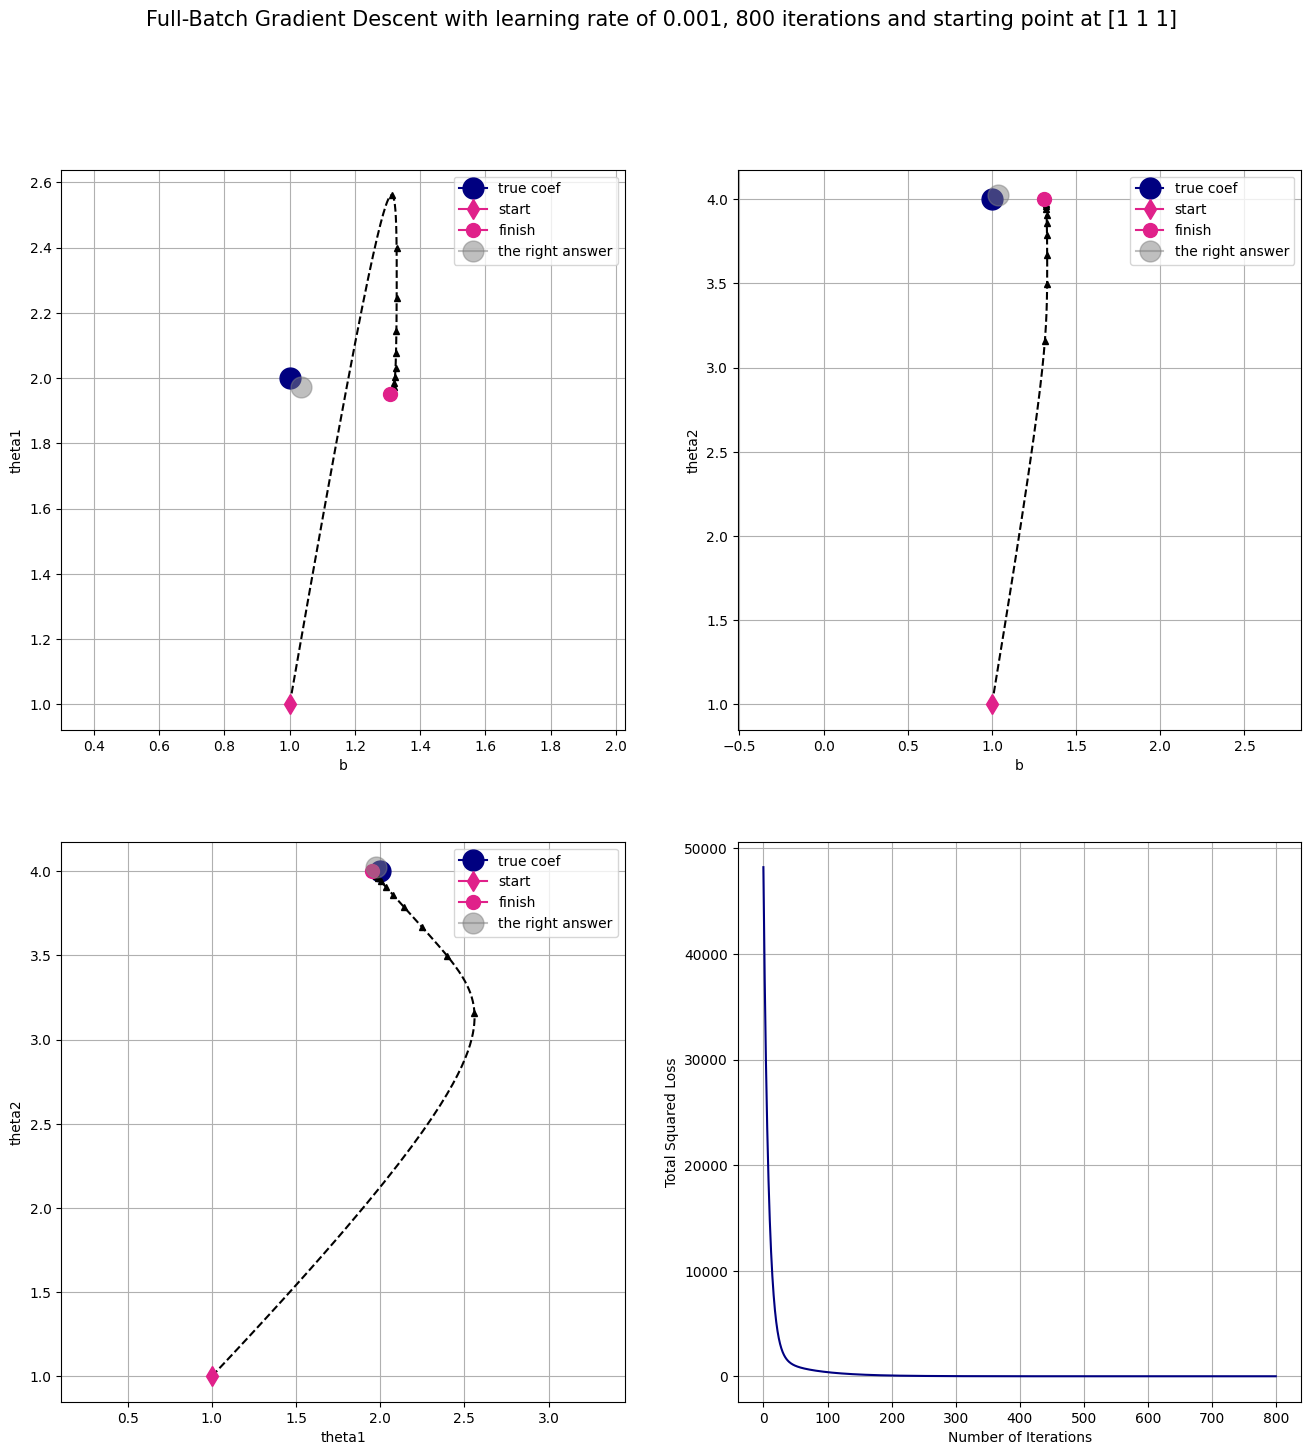

In [253]:
learning_rate = 1e-3
num_iter = 800
theta_initial = np.array([1,1,1])

# Call the function
theta_store, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)
plot_descent_process(theta_store, loss_vec, learning_rate, num_iter, theta_initial)

## 2. (b) Solving by Stochastic Gradient Descent

In [254]:
def stochastic_gradient_descent(learning_rate, num_iter, theta_initial):
    # Setting up the initialization
    theta = theta_initial
    theta_store = np.zeros(((num_iter*sample_size)+1,3))
    theta_store[0,:] = theta_initial
    loss_vec = np.zeros(num_iter*sample_size)
    count = 0
    for i, j in product(range(num_iter), range(sample_size)):
        count += 1
        y_pred = np.dot(theta.T, x_mat.T)
        loss_vec[count - 1] = np.sum((y-y_pred) ** 2)
        grad_vec = (y[j] - y_pred[j]) * (x_mat[j, :])
        theta = theta + learning_rate * grad_vec
        theta_store[count, :] = theta
    return theta_store, loss_vec

Adjust the parameters below for experimentation：

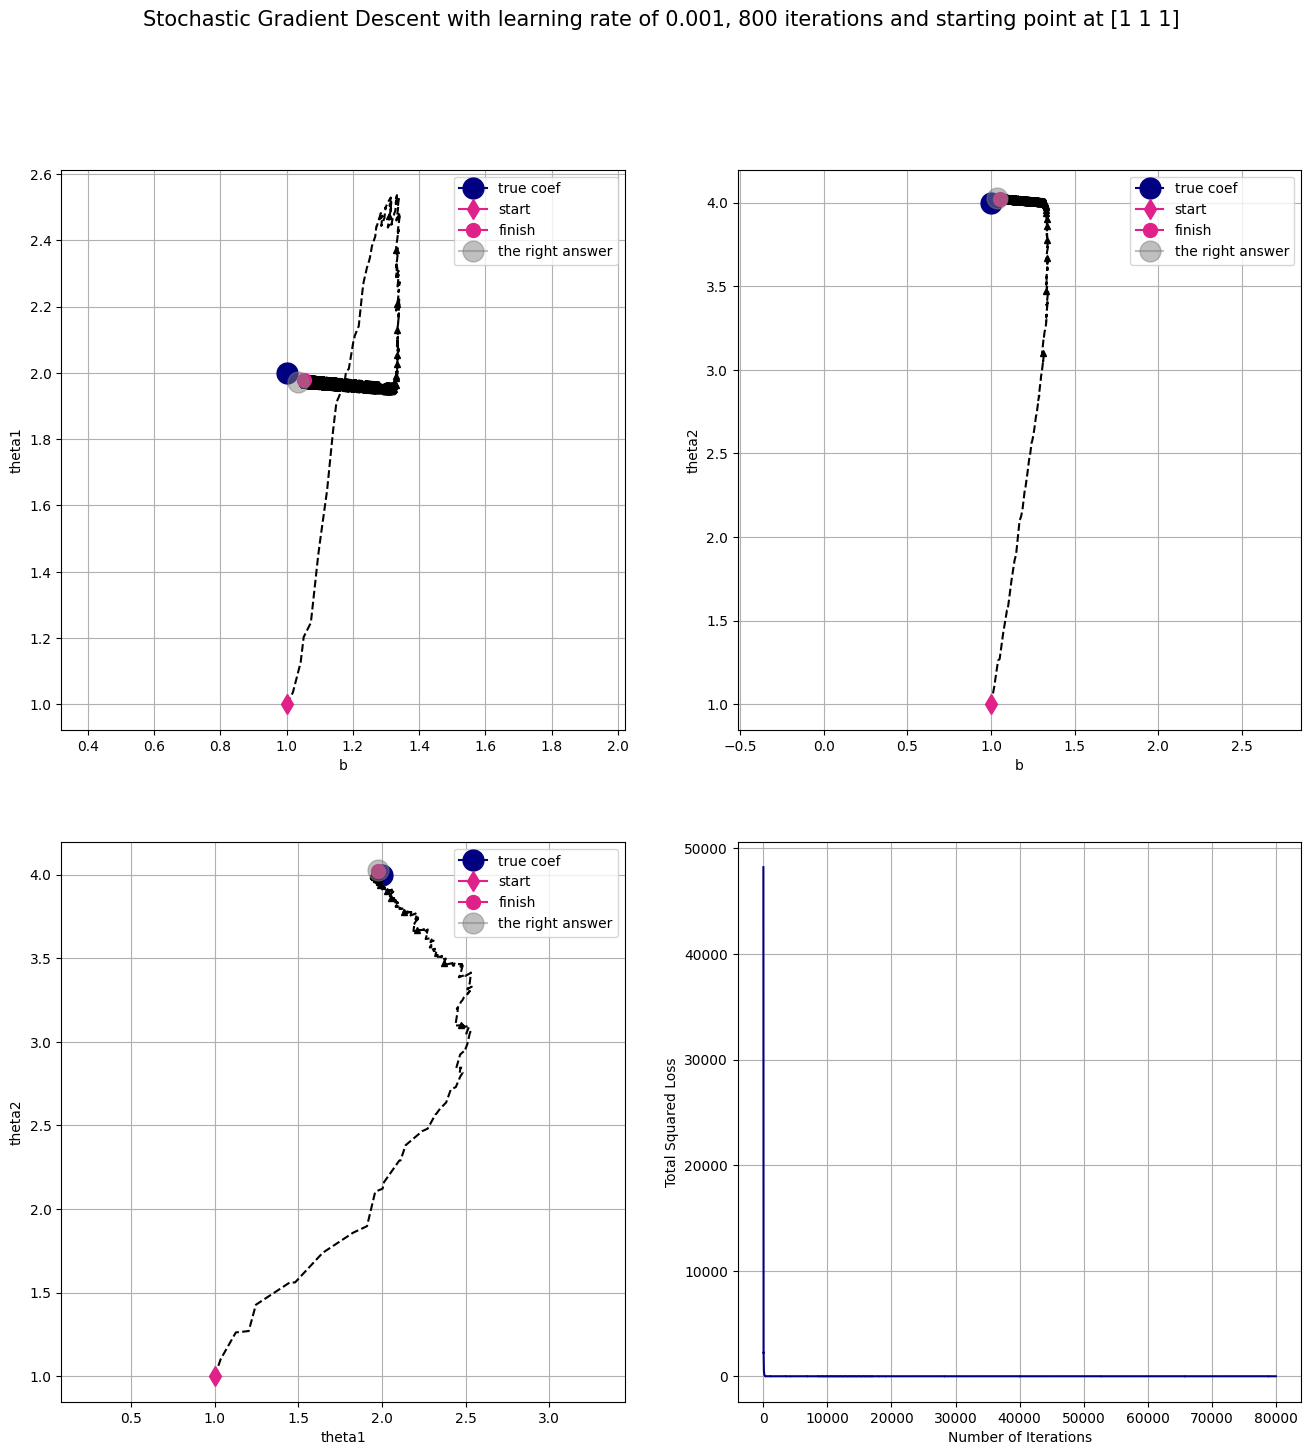

In [255]:
learning_rate = 1e-3
num_iter = 800
theta_initial = np.array([1,1,1])

# Call the function
theta_store, loss_vec = stochastic_gradient_descent(learning_rate, num_iter, theta_initial)
plot_descent_process(theta_store, loss_vec, learning_rate, num_iter, theta_initial, 'Stochastic Gradient Descent')